### 3.1. Dự báo điểm trung bình năm 2026 theo môn

#### 3.1.1. Mục tiêu

- Xây dựng mô hình dự báo **điểm trung bình** các môn thi chính (Toán, Ngữ văn, Ngoại ngữ, các môn tổ hợp) cho năm 2026.
- Xem xét tác động của **“điểm gãy 2025”** lên quỹ đạo điểm trung bình theo thời gian.
- So sánh nhiều mô hình (baseline tuyến tính, mô hình ML/Time-series) và chọn ra kịch bản dự báo hợp lý.

In [1]:
import os
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error

In [2]:
# 1. Lấy đường dẫn của thư mục 'Notebook'
current_dir = os.getcwd() 

# 2. Lấy đường dẫn của thư mục Project_Root (Thư mục cha của 'Notebook' và 'Module')
# Đây là thư mục Project_Root/
project_root_dir = os.path.dirname(current_dir)

# 3. Thêm Project_Root vào sys.path
if project_root_dir not in sys.path:
    sys.path.append(project_root_dir)
    
print(f"Đã thêm đường dẫn gốc: {project_root_dir}")

# Lệnh import này sẽ hoạt động sau khi thêm Project_Root vào sys.path
from Module.Load_Data import DataLoader, CleanDataLoader
from Module.Processor_Data import DataProcessor

Đã thêm đường dẫn gốc: c:\Users\Nam\OneDrive\Documents\PythonProject


In [3]:
# Xây dựng Map chọn môn học
subject_map = {
    1: "toan",
    2: "ngu_van",
    3: "vat_li",
    4: "hoa_hoc",
    5: "sinh_hoc",
    6: "tin_hoc",
    7: "cn_cong_nghiep",
    8: "cn_nong_nghiep",
    9: "lich_su",
    10: "dia_li",
    11: "gdcd",
    12: "ngoai_ngu",
}

print("=== Danh sách môn học ===")
for k, v in subject_map.items():
    print(f"{k}: {v}")

# Load cleaned data: 
clean_data = CleanDataLoader()

=== Danh sách môn học ===
1: toan
2: ngu_van
3: vat_li
4: hoa_hoc
5: sinh_hoc
6: tin_hoc
7: cn_cong_nghiep
8: cn_nong_nghiep
9: lich_su
10: dia_li
11: gdcd
12: ngoai_ngu


In [4]:
# Lấy dữ liệu phân phối và phân tích cho từng môn học
dist_list = []
analysis_list = []

for choice, subject in subject_map.items():

    # ----- DISTRIBUTION -----
    df_dist = clean_data.get_subject_data(
        subject=subject,
        kind="distribution"
    )

    if df_dist is not None and not df_dist.empty:

        # Chuẩn hoá cột môn học
        if "mon_hoc" in df_dist.columns:
            df_dist = df_dist.rename(columns={"mon_hoc": "subject"})
        else:
            df_dist["subject"] = subject

        # Phòng trường hợp vẫn còn 2 cột
        df_dist = df_dist.loc[:, ~df_dist.columns.duplicated()]

        dist_list.append(df_dist)

    # ----- ANALYSIS -----
    df_anal = clean_data.get_subject_data(
        subject=subject,
        kind="analysis"
    )

    if df_anal is not None and not df_anal.empty:

        if "mon_hoc" in df_anal.columns:
            df_anal = df_anal.rename(columns={"mon_hoc": "subject"})
        else:
            df_anal["subject"] = subject

        df_anal = df_anal.loc[:, ~df_anal.columns.duplicated()]

        analysis_list.append(df_anal)

# ----- CONCAT -----
df_distribution = pd.concat(dist_list, ignore_index=True)
df_analysis = pd.concat(analysis_list, ignore_index=True)

print(df_distribution.head() ,"\n")
print(df_analysis.head())

   nam_hoc subject  diem  so_hoc_sinh
0     2023    toan   0.0            2
1     2023    toan   0.2            1
2     2023    toan   0.4            2
3     2023    toan   0.6            4
4     2023    toan   0.8           32 

   nam_hoc      mean  median  mode       std  min   max  subject
0     2023  6.250557     6.6  7.60  1.633336  0.0  10.0     toan
1     2024  6.447309     6.8  7.60  1.556900  0.0   9.8     toan
2     2025  4.799712     4.6  4.75  1.688549  0.0  10.0     toan
3     2023  6.858194     7.0  7.00  1.326471  0.0  10.0  ngu_van
4     2024  7.231146     7.5  8.00  1.330057  0.0  10.0  ngu_van


#### 3.1.2. Chuẩn bị dữ liệu chuỗi theo môn

- Dữ liệu đầu vào: bảng tổng hợp theo **năm–môn** với các cột:
  - `year` (hoặc `nam_hoc`), `subject`,
  - `mean_score`, `median_score`, `std`,
  - `n_students`, cùng một số chỉ báo (tỉ lệ ≥5, ≥8 nếu có).
- Mỗi môn tạo một chuỗi thời gian ngắn 2023–2025 gồm: `mean_score(2023)`, `mean_score(2024)`, `mean_score(2025)` 
(phần này đã được tích hợp vào trong phần ARIMA)
- Tạo thêm các đặc trưng:
  - `year_idx` (mã hoá thời gian),
  - `delta_mean = mean_t - mean_{t-1}`,
  - `post_2025` (0 cho 2023–2024, 1 cho 2025 trở đi)  
    để mô hình nhận biết 2025 là điểm gãy.

In [5]:
n_students_df = (
    df_distribution
    .groupby("nam_hoc")["so_hoc_sinh"]
    .sum()
    .reset_index(name="n_students")
) # Tổng số học sinh theo năm học

summary_df = df_analysis.merge(
    n_students_df,
    on="nam_hoc",
    how="left"
) # Tạo dataframe tổng hợp với số học sinh

summary_df_std = summary_df.copy()
summary_df_std = summary_df_std.rename(columns={
    "nam_hoc": "year",
    "mean": "mean_score",
    "median": "median_score"
}) # Chuẩn hoá tên cột

summary_df_std = summary_df_std[
    ["year", "subject", "mean_score", "median_score", "std", "n_students"]
] # Chuẩn hoá dataframe

print(summary_df_std.head())

   year  subject  mean_score  median_score       std  n_students
0  2023     toan    6.250557           6.6  1.633336     5803574
1  2024     toan    6.447309           6.8  1.556900     6037435
2  2025     toan    4.799712           4.6  1.688549     4579308
3  2023  ngu_van    6.858194           7.0  1.326471     5803574
4  2024  ngu_van    7.231146           7.5  1.330057     6037435


In [6]:
# Hàm xây dựng dataframe cho mô hình học máy
def build_ml_df(df, df_rates=None):
    df = df.sort_values(["subject", "year"]).copy()

    df["post_2025"] = (df["year"] >= 2025).astype(int)

    df["delta_score"] = (
        df.groupby("subject")["mean_score"]
          .diff()
          .fillna(0)
    )

    df["mean_prev"] = (
        df.groupby("subject")["mean_score"]
          .transform(lambda x: x.shift().expanding().mean())
    )

    df["is_first_year"] = (df.groupby("subject").cumcount() == 0).astype(int)

    df["mean_prev"] = (
        df["mean_prev"]
        .fillna(0)
    )

    # ===== merge tỉ lệ nếu có =====
    if df_rates is not None:
        df = df.merge(df_rates, on=["year", "subject"], how="left")
        df[["rate_ge_5", "rate_ge_8"]] = df[["rate_ge_5", "rate_ge_8"]].fillna(0)

    return df

In [7]:
# 1. Chuẩn hóa distribution dataframe
df_dist_std = df_distribution.rename(columns={
    "nam_hoc": "year",
    "diem": "score",
    "so_hoc_sinh": "count"
})

# 2. Tổng số thí sinh
total_students = (
    df_dist_std
    .groupby(["year", "subject"], as_index=False)["count"]
    .sum()
    .rename(columns={"count": "n_students"})
)

# 3. Số thí sinh ≥ 5
ge_5 = (
    df_dist_std[df_dist_std["score"] >= 5]
    .groupby(["year", "subject"], as_index=False)["count"]
    .sum()
    .rename(columns={"count": "n_ge_5"})
)

# 4. Số thí sinh ≥ 8
ge_8 = (
    df_dist_std[df_dist_std["score"] >= 8]
    .groupby(["year", "subject"], as_index=False)["count"]
    .sum()
    .rename(columns={"count": "n_ge_8"})
)

# ===== 5. Gộp các bảng =====
df_rates = (
    total_students
    .merge(ge_5, on=["year", "subject"], how="left")
    .merge(ge_8, on=["year", "subject"], how="left")
)

# ===== 6. Fill missing (nếu không có ai ≥5 hoặc ≥8) =====
df_rates[["n_ge_5", "n_ge_8"]] = df_rates[["n_ge_5", "n_ge_8"]].fillna(0)

# ===== 7. Tính tỉ lệ =====
df_rates["rate_ge_5"] = df_rates["n_ge_5"] / df_rates["n_students"]
df_rates["rate_ge_8"] = df_rates["n_ge_8"] / df_rates["n_students"]

df_rates = df_rates[[
    "year", "subject", "rate_ge_5", "rate_ge_8"
]]

df_ml = build_ml_df(summary_df_std, df_rates)
print(df_ml.head())

   year         subject  mean_score  median_score       std  n_students  \
0  2025  cn_cong_nghiep    5.792555          5.60  1.539870     4579308   
1  2025  cn_nong_nghiep    7.715897          7.75  1.170514     4579308   
2  2023          dia_li    6.147523          6.25  1.168732     5803574   
3  2024          dia_li    7.193541          7.25  1.283945     6037435   
4  2025          dia_li    6.642910          6.75  1.750127     4579308   

   post_2025  delta_score  mean_prev  is_first_year  rate_ge_5  rate_ge_8  
0          1     0.000000   0.000000              1   0.659389   0.112227  
1          1     0.000000   0.000000              1   0.978547   0.487981  
2          0     0.000000   0.000000              1   0.866488   0.066412  
3          0     1.046018   6.147523              0   0.956368   0.310090  
4          1    -0.550631   6.670532              0   0.815334   0.270256  


#### 3.1.3. Các mô hình dự báo điểm trung bình

(Cụ thể điền đúng theo các mô hình đã implement trong Notebook)

- **Baseline tuyến tính**:
  - Hồi quy tuyến tính đơn giản theo `year_idx` cho từng môn.
- **Mô hình ML / Time-series**:
  - Ví dụ: Random Forest / Gradient Boosting trên bảng đặc trưng,
  - hoặc ARIMA/Prophet riêng cho từng chuỗi môn.
- Các mô hình được huấn luyện trên dữ liệu năm 2023–2025
  (hoặc thêm 2018–2022 nếu có dữ liệu lịch sử cùng chương trình).

- ARIMA

Mô hình ARIMA được xây dựng riêng cho từng môn học,
sử dụng chuỗi thời gian điểm trung bình theo năm.
Biến giả `post_2025` được thêm vào (ARIMAX) để mô hình
nhận biết sự thay đổi cấu trúc sau năm 2025.

In [8]:
# Hàm hỗ trợ tính MAE, RMSE, MAPE 
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def mape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

class ArimaSubjectModel:
    """
    ARIMA / ARIMAX theo từng môn học
    - scenario = "raw"  : ARIMA
    - scenario = "post" : ARIMAX (post_2025)

    Xuất ra dataframe kèm MAE trung bình của tất cả các môn
    """

    def __init__(self, min_points_for_ar1=4):
        self.min_points_for_ar1 = min_points_for_ar1

    # =========================
    # Utils
    # =========================
    @staticmethod
    def _to_series(df, value_col):
        years = df["year"].astype(int)
        values = pd.to_numeric(df[value_col], errors="coerce")
        return pd.Series(
            values.values,
            index=pd.PeriodIndex(years, freq="Y")
        ).asfreq("Y")

    @staticmethod
    def _to_exog(df, exog_col):
        years = df["year"].astype(int)
        values = pd.to_numeric(df[exog_col], errors="coerce")
        return pd.DataFrame(
            values.values,
            index=pd.PeriodIndex(years, freq="Y"),
            columns=[exog_col]
        ).asfreq("Y")

    # =========================
    # Fit + forecast 1 môn
    # =========================
    def _fit_and_forecast_one(self, df_sub, target_year, scenario):
        df_sub = df_sub.sort_values("year")

        df_train = df_sub[df_sub["year"] < target_year]
        df_test  = df_sub[df_sub["year"] == target_year]

        if len(df_train) == 0 or len(df_test) == 0:
            return None

        y_train = self._to_series(df_train, "mean_score")

        # chọn AR order
        if len(y_train.dropna()) < self.min_points_for_ar1:
            order = (0, 0, 0)
        else:
            order = (1, 0, 0)

        last_value = float(y_train.dropna().iloc[-1])

        try:
            # ===== ARIMAX =====
            if scenario == "post" and "post_2025" in df_train.columns:
                exog_train = self._to_exog(df_train, "post_2025")
                model = ARIMA(y_train, order=order, exog=exog_train).fit()

                exog_future = pd.DataFrame(
                    [1 if target_year >= 2025 else 0],
                    index=pd.PeriodIndex([target_year], freq="Y"),
                    columns=["post_2025"]
                )

                y_pred = float(model.forecast(steps=1, exog=exog_future).iloc[0])

            # ===== ARIMA raw =====
            else:
                model = ARIMA(y_train, order=order).fit()
                y_pred = float(model.forecast(steps=1).iloc[0])

        except Exception:
            y_pred = last_value

        y_true = float(df_test["mean_score"].iloc[0])
        err = y_true - y_pred

        return {
            "mean_true": y_true,
            "mean_pred": y_pred,
            "MAE": abs(err),
            "RMSE": abs(err),
            "MAPE": abs(err) / y_true * 100 if y_true != 0 else np.nan
        }

    # =========================
    # Evaluate ALL subjects
    # =========================
    def evaluate_year(self, df_all, year, scenario="post", verbose=True):
        """
        scenario:
            - "raw"  : không dùng post_2025
            - "post" : dùng post_2025
        """
        results = []

        for subject, df_sub in df_all.groupby("subject"):
            res = self._fit_and_forecast_one(df_sub, year, scenario)
            if res is None:
                continue

            res["subject"] = subject
            results.append(res)

        if len(results) == 0:
            return pd.DataFrame(
                columns=["subject", "mean_true", "mean_pred", "MAE", "RMSE", "MAPE"]
            )

        df_result = pd.DataFrame(results)[
            ["subject", "mean_true", "mean_pred", "MAE", "RMSE", "MAPE"]
        ]

        mean_mae = df_result["MAE"].mean()
        n_subject = len(df_result)

        if verbose:
            tag = "ARIMAX" if scenario == "post" else "ARIMA"
            print(f"[{tag} {n_subject} subject] MAE ({year}) = {mean_mae:.4f}")

        return df_result


- Random Forest Regressor

Mô hình Random Forest Regressor được huấn luyện trên toàn bộ dữ liệu các môn,
sử dụng các đặc trưng:
- mean_prev
- delta_score
- rate_ge_5
- rate_ge_8
- post_2025 (nếu có)

Các môn học được mã hóa one-hot (`subject_*`).

In [9]:
class RFGlobalModel:
    """
    RandomForestRegressor train chung cho tất cả môn
    subject được mã hóa one-hot

    Xuất ra dataframe kèm MAE trung bình của tất cả các môn
    """

    def __init__(
        self,
        base_features=None,
        n_estimators=300,
        max_depth=None,
        random_state=42
    ):
        self.base_features = base_features or [
            "rate_ge_5",
            "rate_ge_8",
            "is_first_year"
        ]

        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.random_state = random_state

        self.model = None
        self.subject_cols = None

    # =========================
    # Feature builder
    # =========================
    def build_features(self, df, scenario):
        df = df.copy()

        if scenario == "raw":
            df["post_2025"] = 0

        # one-hot subject
        subject_ohe = pd.get_dummies(df["subject"], prefix="subject")

        # align columns khi train / test
        if self.subject_cols is None:
            self.subject_cols = subject_ohe.columns.tolist()
        else:
            subject_ohe = subject_ohe.reindex(
                columns=self.subject_cols, fill_value=0
            )

        X = pd.concat(
            [
                df[self.base_features + ["post_2025"]],
                subject_ohe
            ],
            axis=1
        )

        return X

    # =========================
    # Fit
    # =========================
    def fit(self, df_train, scenario):
        X_train = self.build_features(df_train, scenario)
        y_train = df_train["mean_score"]

        self.model = RandomForestRegressor(
            n_estimators=self.n_estimators,
            max_depth=self.max_depth,
            random_state=self.random_state
        )

        self.model.fit(X_train, y_train)

    # =========================
    # Predict year
    # =========================
    def predict_year(self, df_test, scenario):
        X_test = self.build_features(df_test, scenario)
        df_test = df_test.copy()
        df_test["mean_pred"] = self.model.predict(X_test)
        return df_test

    # =========================
    # Evaluate year
    # =========================
    def evaluate_year(self, X_test, scenario="post"):
            df_pred = self.predict_year(X_test, scenario=scenario)

            df_pred["mean_true"] = df_pred["mean_score"]
            df_pred["MAE"] = np.abs(df_pred["mean_true"] - df_pred["mean_pred"])
            df_pred["RMSE"] = df_pred["MAE"]  # 1 điểm / môn
            df_pred["MAPE"] = (
                df_pred["MAE"] / df_pred["mean_true"] * 100
            )

            result = df_pred[
                ["subject", "mean_true", "mean_pred", "MAE", "RMSE", "MAPE"]
            ]

            print(
                f"[RF-global-{scenario} {result['subject'].nunique()} subject] "
                f"MAE (2025) = {result['MAE'].mean():.4f}"
            )

            return result


- XGBoost (xây dựng tương tự mô hình Random Forest Regressor)

In [10]:
class XGBGlobalModel:
    """
    XGBoost train chung cho tất cả môn
    subject được mã hóa one-hot

    Xuất ra dataframe kèm MAE trung bình của tất cả các môn
    """
    def __init__(
        self,
        features_base=None,
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ):
        # base features (KHÔNG gồm subject)
        self.features_base = features_base or [
            "rate_ge_5",
            "rate_ge_8",
            "is_first_year",
            "post_2025"
        ]

        self.model = XGBRegressor(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            objective="reg:squarederror",
            random_state=random_state
        )

        self.subject_ohe_cols = None

    # --------------------------------------------------
    # Build features (numeric + subject one-hot)
    # --------------------------------------------------
    def build_features(self, df, scenario="post", fit_ohe=False):
        df = df.copy()

        # xử lý scenario post_2025
        if scenario == "raw":
            df["post_2025"] = 0

        X_num = df[self.features_base].copy()

        # one-hot subject
        X_sub = pd.get_dummies(df["subject"], prefix="subject")

        if fit_ohe:
            self.subject_ohe_cols = X_sub.columns
        else:
            X_sub = X_sub.reindex(columns=self.subject_ohe_cols, fill_value=0)

        return pd.concat([X_num, X_sub], axis=1)

    # --------------------------------------------------
    # Fit
    # --------------------------------------------------
    def fit(self, X_train, scenario="post"):
        X = self.build_features(X_train, scenario=scenario, fit_ohe=True)
        y = X_train["mean_score"].values
        self.model.fit(X, y)

    # --------------------------------------------------
    # Predict whole year (one row per subject)
    # --------------------------------------------------
    def predict_year(self, X_test, scenario="post"):
        X = self.build_features(X_test, scenario=scenario, fit_ohe=False)
        preds = self.model.predict(X)

        df_pred = X_test.copy()
        df_pred["mean_pred"] = preds

        return df_pred[["subject", "mean_score", "mean_pred"]]

    # --------------------------------------------------
    # Evaluate year → bảng chuẩn
    # --------------------------------------------------
    def evaluate_year(self, X_test, scenario="post"):
        df_pred = self.predict_year(X_test, scenario=scenario)

        df_pred["mean_true"] = df_pred["mean_score"]
        df_pred["MAE"] = np.abs(df_pred["mean_true"] - df_pred["mean_pred"])
        df_pred["RMSE"] = df_pred["MAE"]  # 1 điểm / môn
        df_pred["MAPE"] = (
            df_pred["MAE"] / df_pred["mean_true"] * 100
        )

        result = df_pred[
            ["subject", "mean_true", "mean_pred", "MAE", "RMSE", "MAPE"]
        ]

        print(
            f"[XGB-global-{scenario} {result['subject'].nunique()} subject] "
            f"MAE (2025) = {result['MAE'].mean():.4f}"
        )

        return result


#### 3.1.4. Chiến lược đánh giá

- Sử dụng **backtest theo thời gian**:
  - Train trên 2023, dự báo 2024 → tính sai số.
  - Train trên 2023–2024, dự báo 2025 → tính sai số.
- Chỉ số đánh giá: MAE / RMSE giữa điểm trung bình dự báo và thực tế theo từng môn.
- Chọn mô hình có sai số thấp và đường dự báo hợp lý (không quá “gãy khúc” so với bối cảnh đổi mới đề thi).

- Mô hình XGBoost có sai số thấp nhất được chọn làm mô hình dự báo cho năm 2026

ARIMA

In [11]:
arima = ArimaSubjectModel(min_points_for_ar1=4)

# Không post_2025
arima_raw_2025 = arima.evaluate_year(df_ml, year=2025, scenario="raw")
print(arima_raw_2025)

# Chỉ số MAE của ARIMA cao là do vài lí do:  
# Thứ nhất: ARIMA chỉ dự đoán cho các môn có số năm >=2
# Thứ hai: Các môn tin học, cn nông nghiệp và cn công nghiệp chỉ có 1 năm 2025 nên ARIMA tự loại ra
# Không in có post_2025 do cả 2 giống nhau
# Tương tự cho RF và XGB

[ARIMA 9 subject] MAE (2025) = 0.4470
     subject  mean_true  mean_pred       MAE      RMSE       MAPE
0     dia_li   6.642910   6.670527  0.027617  0.027617   0.415731
1       gdcd   7.691509   8.221150  0.529641  0.529641   6.886051
2    hoa_hoc   6.069784   6.712733  0.642949  0.642949  10.592625
3    lich_su   6.514921   6.297981  0.216940  0.216940   3.329893
4  ngoai_ngu   5.406338   5.492169  0.085832  0.085832   1.587614
5    ngu_van   6.990479   7.044665  0.054186  0.054186   0.775143
6   sinh_hoc   5.780638   6.339501  0.558862  0.558862   9.667832
7       toan   4.799712   6.348928  1.549216  1.549216  32.277275
8     vat_li   6.978461   6.620378  0.358082  0.358082   5.131249


RandomForestRegressor

In [12]:
YEAR_FOR_TEST = int(df_ml["year"].max())  # 2025

X_train = df_ml.loc[df_ml["year"] < YEAR_FOR_TEST].copy()
X_test = df_ml.loc[df_ml["year"] == YEAR_FOR_TEST].copy()

rf = RFGlobalModel()
 
# -------- RAW (không post_2025)
rf.fit(X_train, scenario="raw")
pred_raw = rf.predict_year(X_test, scenario="raw")

eval_raw = rf.evaluate_year(pred_raw, scenario="raw")
print(eval_raw)

[RF-global-raw 12 subject] MAE (2025) = 0.2215
           subject  mean_true  mean_pred       MAE      RMSE       MAPE
0   cn_cong_nghiep   5.792555   5.939228  0.146673  0.146673   2.532100
1   cn_nong_nghiep   7.715897   7.633283  0.082614  0.082614   1.070701
4           dia_li   6.642910   6.678771  0.035860  0.035860   0.539828
7             gdcd   7.691509   7.839566  0.148058  0.148058   1.924948
10         hoa_hoc   6.069784   6.341543  0.271760  0.271760   4.477257
13         lich_su   6.514921   6.655841  0.140919  0.140919   2.163023
16       ngoai_ngu   5.406338   5.636303  0.229965  0.229965   4.253623
19         ngu_van   6.990479   6.877618  0.112861  0.112861   1.614500
22        sinh_hoc   5.780638   6.047595  0.266957  0.266957   4.618116
23         tin_hoc   6.782761   6.731042  0.051719  0.051719   0.762505
26            toan   4.799712   5.896125  1.096413  1.096413  22.843307
29          vat_li   6.978461   6.904139  0.074322  0.074322   1.065013


XGBoost

In [13]:
xgb = XGBGlobalModel()

# -------- RAW (không post_2025)
xgb.fit(X_train, scenario="raw")
df_xgb_raw = xgb.evaluate_year(X_test, scenario="raw")
print(df_xgb_raw)

[XGB-global-raw 12 subject] MAE (2025) = 0.2017
           subject  mean_true  mean_pred       MAE      RMSE       MAPE
0   cn_cong_nghiep   5.792555   5.668400  0.124155  0.124155   2.143351
1   cn_nong_nghiep   7.715897   7.236302  0.479595  0.479595   6.215677
4           dia_li   6.642910   6.653750  0.010840  0.010840   0.163182
7             gdcd   7.691509   7.290098  0.401411  0.401411   5.218883
10         hoa_hoc   6.069784   6.003318  0.066465  0.066465   1.095019
13         lich_su   6.514921   6.649900  0.134979  0.134979   2.071846
16       ngoai_ngu   5.406338   5.511889  0.105551  0.105551   1.952355
19         ngu_van   6.990479   6.869039  0.121440  0.121440   1.737220
22        sinh_hoc   5.780638   5.773340  0.007298  0.007298   0.126252
23         tin_hoc   6.782761   6.723589  0.059172  0.059172   0.872391
26            toan   4.799712   5.530846  0.731134  0.731134  15.232871
29          vat_li   6.978461   6.799952  0.178508  0.178508   2.557992


Kết luận:

- ARIMA phù hợp với các môn có chuỗi thời gian ổn định
- Random Forest cho kết quả tốt khi dữ liệu có nhiều feature
- XGBoost cho hiệu năng cao nhất nhưng dễ overfitting nếu dữ liệu ít

Trong bối cảnh số năm quan sát hạn chế,
XGBoost với post_2025 chung cho tất cả môn là lựa chọn hợp lý.

#### 3.1.5. Quy trình dự báo điểm trung bình năm 2026

- Dùng mô hình tốt nhất để:
  - Huấn luyện trên toàn bộ chuỗi hiện có (trước 2026).
  - Dự báo `mean_score_2026` cho từng môn.
- Nếu 2025 là điểm gãy mạnh:
  - Có thể tách riêng **regime sau 2025** hoặc dùng feature `post_2025`
    để mô hình không kéo trend 2018–2024 một cách máy móc.
- Thu được bảng:
  \[
    \texttt{subject, year, mean\_actual, mean\_predicted}
  \]
  trong đó:
  - `mean_actual` có cho 2023–2025,
  - `mean_predicted` có cho 2026.

In [14]:
from scipy.stats import norm

def forecast_2026_xgb_with_ci(
    model,
    df_ml,
    year_start=2023,
    year_end=2026,
    alpha=0.05,
    scenario="post"
):
    """
    Forecast điểm thi bằng XGBoost và xuất bảng:
    subject | year | mean_actual | mean_predicted | lower_CI | upper_CI
    """

    df_ml = df_ml.copy()

    # =========================
    # 1. Fit model + residuals
    # =========================
    X_train = df_ml[df_ml["year"] <= 2025]

    X_feat = model.build_features(X_train, scenario=scenario, fit_ohe=True)
    y_train = X_train["mean_score"].values

    model.model.fit(X_feat, y_train)

    y_hat_train = model.model.predict(X_feat)
    # Sử dụng Residual based CI do phù hợp với điều kiện
    resid_std = np.std(y_train - y_hat_train)

    z = norm.ppf(1 - alpha / 2)

    results = []

    # =========================
    # 2. Predict 2023–2025
    # =========================
    for year in range(year_start, 2026):
        df_year = df_ml[df_ml["year"] == year].copy()
        if df_year.empty:
            continue

        X_year = model.build_features(df_year, scenario=scenario, fit_ohe=False)
        y_pred = model.model.predict(X_year)

        df_year["year"] = year
        df_year["mean_actual"] = df_year["mean_score"]
        df_year["mean_predicted"] = y_pred
        df_year["lower_CI"] = y_pred - z * resid_std
        df_year["upper_CI"] = y_pred + z * resid_std

        results.append(
            df_year[
                ["subject", "year", "mean_actual",
                 "mean_predicted", "lower_CI", "upper_CI"]
            ]
        )

    # =========================
    # 3. Tạo feature cho 2026
    # =========================
    subjects = df_ml["subject"].unique()
    df_2026 = pd.DataFrame({
        "subject": subjects,
        "year": 2026,
        "post_2025": 1,
        "is_first_year": 0
    })

    # carry-forward rate
    for col in ["rate_ge_5", "rate_ge_8"]:
        if col in df_ml.columns:
            df_2026[col] = (
                df_ml[df_ml["year"] == 2025]
                .set_index("subject")[col]
                .reindex(subjects)
                .values
            )

    # =========================
    # 4. Predict 2026
    # =========================
    X_2026 = model.build_features(df_2026, scenario=scenario, fit_ohe=False)
    y_2026 = model.model.predict(X_2026)

    df_2026["mean_actual"] = np.nan
    df_2026["mean_predicted"] = y_2026
    df_2026["lower_CI"] = y_2026 - z * resid_std
    df_2026["upper_CI"] = y_2026 + z * resid_std

    results.append(
        df_2026[
            ["subject", "year", "mean_actual",
             "mean_predicted", "lower_CI", "upper_CI"]
        ]
    )

    # =========================
    # 5. Gộp bảng
    # =========================
    df_final = (
        pd.concat(results)
        .sort_values(["subject", "year"])
        .reset_index(drop=True)
    )

    return df_final


In [15]:
xgb = XGBGlobalModel()

df_forecast = forecast_2026_xgb_with_ci(
    model=xgb,
    df_ml=df_ml,
    scenario="post"
)

df_forecast.head()
print(df_forecast)

           subject  year  mean_actual  mean_predicted  lower_CI  upper_CI
0   cn_cong_nghiep  2025     5.792555        5.789268  5.779650  5.798887
1   cn_cong_nghiep  2026          NaN        5.787074  5.777455  5.796692
2   cn_nong_nghiep  2025     7.715897        7.714726  7.705108  7.724345
3   cn_nong_nghiep  2026          NaN        7.711232  7.701613  7.720850
4           dia_li  2023     6.147523        6.153481  6.143862  6.163100
5           dia_li  2024     7.193541        7.194930  7.185311  7.204549
6           dia_li  2025     6.642910        6.640637  6.631018  6.650256
7           dia_li  2026          NaN        6.640637  6.631018  6.650256
8             gdcd  2023     8.285805        8.279157  8.269538  8.288775
9             gdcd  2024     8.156503        8.159615  8.149996  8.169233
10            gdcd  2025     7.691509        7.697098  7.687479  7.706717
11            gdcd  2026          NaN        7.697098  7.687479  7.706717
12         hoa_hoc  2023     6.744646 

#### 3.1.6. Trực quan hoá và diễn giải

- Vẽ biểu đồ line theo từng môn:
  - Đường thực tế 2023–2025,
  - Điểm/đoạn dự báo 2026 (kèm khoảng tin cậy nếu có).
- Nhận xét:
  - Môn nào dự kiến giảm / tăng sau khi đổi chương trình (so với 2025),
  - Môn nào giữ xu hướng ổn định.

In [17]:
def plot_subject_forecast(df, subject):
    """
    Hàm dùng để vẽ biểu đồ line chồng chất
    """
    df_sub = df[df["subject"] == subject].sort_values("year")

    df_true = df_sub[df_sub["year"] <= 2025]
    df_pred = df_sub[df_sub["year"] >= 2025]

    plt.figure(figsize=(8, 5))

    # ----- giá trị thật 2023–2025 -----
    plt.plot(
        df_true["year"],
        df_true["mean_actual"],
        marker="o",
        label="Thực tế (2023–2025)"
    )

    # ----- dự báo (2025–2026) -----
    plt.plot(
        df_pred["year"],
        df_pred["mean_predicted"],
        marker="o",
        linestyle="--",
        label="Dự báo năm 2026"
    )

    # ----- dải tin cậy -----
    plt.fill_between(
        df_pred["year"],
        df_pred["lower_CI"],
        df_pred["upper_CI"],
        alpha=0.4,
        label="Confidence Interval"
    )

    plt.title(f"Dự đoán điểm trung bình môn – {subject}")
    plt.xlabel("Năm")
    plt.ylabel("Điểm trung bình")
    plt.xticks(df_sub["year"].unique())
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


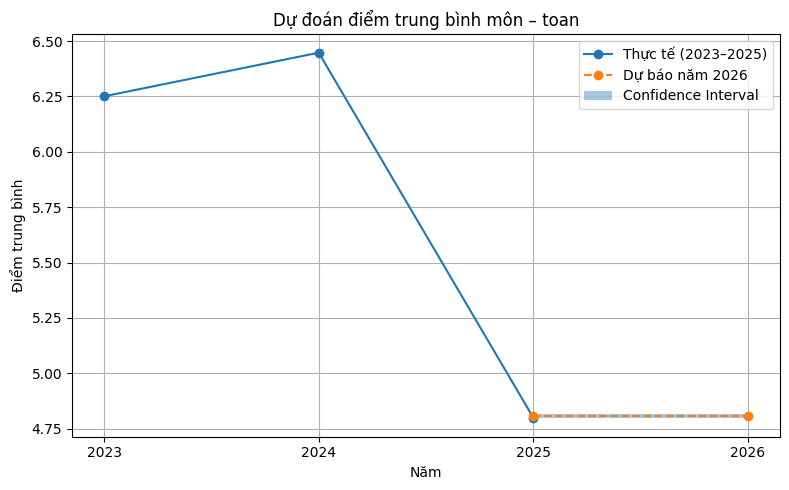

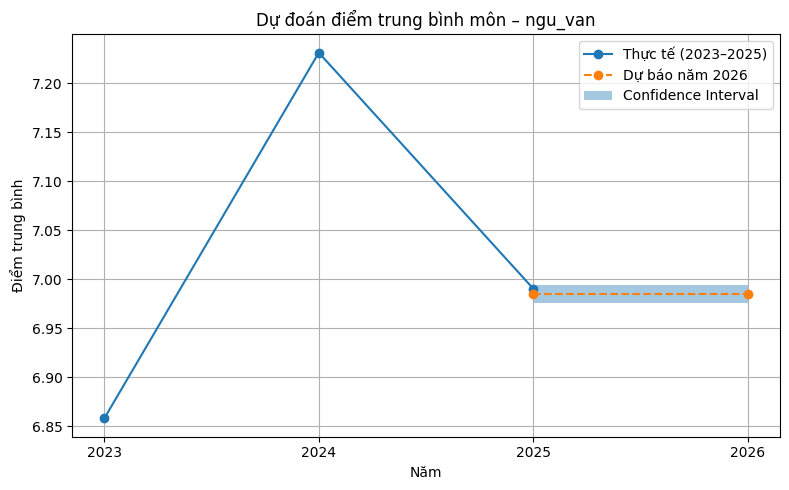

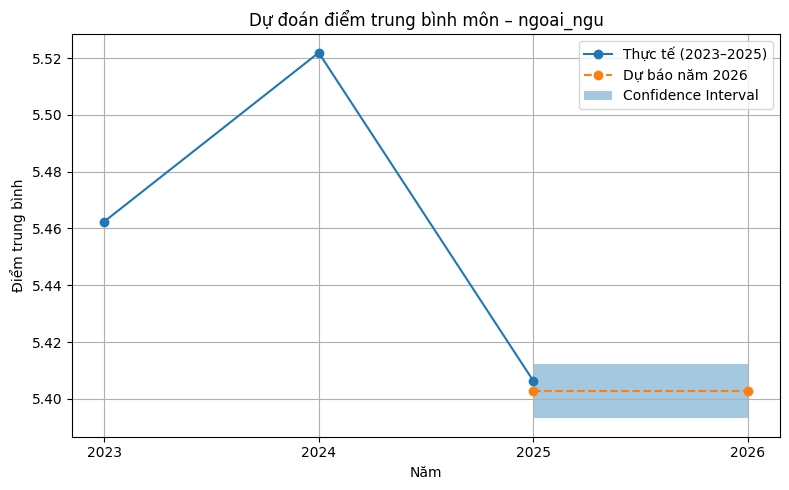

In [18]:
subjcol = ['toan', 'ngu_van', 'ngoai_ngu'] # test thử vài môn
for subject in subjcol:
    plot_subject_forecast(df_forecast, subject)

#### 3.1.7. Hạn chế và hướng mở rộng

- Chuỗi thời gian ngắn → khó mô hình hoá trend dài hạn.
- Dự báo 2026 chịu ảnh hưởng mạnh từ giả định về **tính ổn định của regime mới sau 2025**.
- Hướng phát triển:
  - Bổ sung thêm dữ liệu các năm tiếp theo,
  - Kết hợp thêm thông tin về chính sách, cấu trúc đề thi, phân bố tổ hợp… vào mô hình.

---

### Dự báo tỉ lệ tổ hợp khối thi năm 2026

#### Mục tiêu

- Dự báo **tỉ lệ thí sinh đăng ký các khối chính** (A00, A01, B00, C00, D01, D07, D08, D09, A02, A03) trong năm 2026.
- Tôn trọng thực tế **năm 2025 là “điểm gãy”** do thay đổi chương trình thi, coi 2025 là năm đầu của **regime mới** và 2026 là năm tiếp theo trong cùng regime.
- So sánh, đánh giá mức dịch chuyển tỉ lệ khối thi giữa 3 năm 2023–2025 và kịch bản dự báo cho 2026.


In [23]:
import pandas as pd
from pathlib import Path
from Module.Load_Data import CleanDataLoader
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge  
from sklearn.metrics import mean_absolute_error, r2_score


def load_all_block_analysis_with_features(
    clean_data: CleanDataLoader,
) -> pd.DataFrame:
    """
    - Đọc toàn bộ Export_Analysis_<BLOCK>.csv và Export_Distribution_<BLOCK>.csv
      từ Block_Data để tạo bảng feature cho train.
    - Thêm:
        + n_students: số thí sinh của khối đó trong từng năm (từ distribution)
        + total_students_year: tổng số thí sinh toàn năm (từ clean_data.get_total_students())
      (KHÔNG tính share_in_year ở đây, sẽ tính sau khi gộp khoi_group)
    """

    block_root: Path = clean_data.block_data_root
    if not block_root.exists():
        raise FileNotFoundError(f"Block_Data folder không tồn tại: {block_root}")

    all_dfs = []

    # Tiền tố folder: CleanData_<BLOCK> (ví dụ CleanData_A00)
    folder_prefix = clean_data._block_data_f_prefix + "_"   # "CleanData_"

    for sub in block_root.iterdir():
        if not sub.is_dir():
            continue

        folder_name = sub.name
        if not folder_name.startswith(folder_prefix):
            continue

        # Lấy mã khối: CleanData_A00 -> A00
        block_code = folder_name[len(folder_prefix):]

        # 1) Đọc file analysis
        try:
            df_anal = clean_data.get_block_data(block=block_code, kind="analysis").copy()
        except FileNotFoundError:
            continue

        if "khoi" not in df_anal.columns:
            df_anal["khoi"] = block_code

        # 2) Đọc file distribution để đếm n_students theo năm
        try:
            df_dist = clean_data.get_block_data(block=block_code, kind="distribution").copy()
        except FileNotFoundError:
            df_dist = pd.DataFrame(columns=["nam_hoc", "so_hoc_sinh"])

        if not df_dist.empty:
            # Xác định cột đếm số học sinh
            if "so_hoc_sinh" in df_dist.columns:
                cnt_col = "so_hoc_sinh"
                counts = (
                    df_dist.groupby("nam_hoc")[cnt_col]
                           .sum()
                           .reset_index(name="n_students")
                )
            elif "count" in df_dist.columns:
                cnt_col = "count"
                counts = (
                    df_dist.groupby("nam_hoc")[cnt_col]
                           .sum()
                           .reset_index(name="n_students")
                )
            else:
                # fallback: chỉ đếm số dòng theo năm
                counts = (
                    df_dist.groupby("nam_hoc")
                           .size()
                           .reset_index(name="n_students")
                )
        else:
            counts = pd.DataFrame(columns=["nam_hoc", "n_students"])

        # 3) Merge n_students vào analysis
        df_merged = df_anal.merge(counts, on="nam_hoc", how="left")
        all_dfs.append(df_merged)

    if not all_dfs:
        return pd.DataFrame()

    block_analysis_all = pd.concat(all_dfs, ignore_index=True)

    # --- 4. Lấy tổng số thí sinh theo năm từ CleanDataLoader ---
    df_total = clean_data.get_total_students().copy()

    # Chuẩn hoá tên cột tổng số thí sinh về 'total_students_year'
    if "total_students_year" not in df_total.columns:
        for cand in ["tong_thi_sinh", "total_students", "so_thi_sinh",
                     "tong_hoc_sinh", "n_students"]:
            if cand in df_total.columns:
                df_total = df_total.rename(columns={cand: "total_students_year"})
                break

    if "nam_hoc" not in df_total.columns:
        raise ValueError(
            "DataFrame từ get_total_students() phải có cột 'nam_hoc'."
        )

    # Merge tổng thí sinh năm vào bảng feature
    block_analysis_all = block_analysis_all.merge(
        df_total[["nam_hoc", "total_students_year"]],
        on="nam_hoc",
        how="left"
    )

    # KHÔNG tính share_in_year ở đây nữa
    return block_analysis_all


In [24]:
clean_data = CleanDataLoader(project_root=project_root_dir)

df_block_features = load_all_block_analysis_with_features(clean_data=clean_data)
df_block_features

,nam_hoc,mean,median,mode,std,min,max,khoi,n_students,total_students_year
0,2023,20.774499,21.150,22.10,3.094093,0.45,29.35,A00,325902,1017584
1,2024,20.904633,21.300,22.80,3.380354,2.15,29.60,A00,343800,1061604
2,2025,19.384368,19.250,22.00,4.337350,1.70,30.00,A00,165467,1153072
3,2023,20.275288,20.450,20.50,3.339521,5.05,29.80,A01,315146,1017584
4,2024,20.473793,20.750,21.00,3.350473,5.20,29.60,A01,329761,1061604
...,...,...,...,...,...,...,...,...,...,...
152,2025,20.486105,20.750,21.50,2.593046,8.95,26.50,Y07,475,1153072
153,2025,19.659654,19.900,21.00,2.518257,13.25,25.25,Y08,260,1153072
154,2025,21.366093,21.750,22.75,2.741671,7.25,28.50,Y09,9493,1153072
155,2025,17.617708,16.925,16.60,2.435760,13.95,24.00,Y10,48,1153072


#### Chuẩn bị dữ liệu cho mô hình

- Dữ liệu đầu vào: bảng tổng hợp theo **năm–khối** `df_block_features` với các cột:
  - `nam_hoc`, `khoi`, `mean`, `median`, `mode`, `std`, `min`, `max`,
  - `n_students`, `total_students_year`.
- Chọn **10 khối chính** để phân tích: `TOP_BLOCKS = ["A00", "A01", "B00", "C00", "D01", "D07", "D08", "D09", "A02", "A03"]`.
- Tạo bảng làm việc `df_top`:
  - Lọc theo `TOP_BLOCKS`.
  - Chuẩn hoá kiểu dữ liệu (`nam_hoc` dạng số nguyên).
- Tính **tỉ lệ trong năm** cho từng khối:
  - `share_in_year = n_students / total_students_year`.
  - Chuẩn hoá lại trong 10 khối: tổng `share_in_year` theo từng năm ≈ 1.
- Tạo thêm các đặc trưng:
  - `year_idx = nam_hoc - nam_hoc.min()` (chỉ số thời gian).
  - `share_lag1`: độ trễ 1 năm theo từng khối (share năm trước).
  - `delta_share = share_in_year - share_lag1` (mức thay đổi so với năm trước).
  - `post_2025 = 1` nếu `nam_hoc ≥ 2025`, ngược lại `0`  
    → mã hoá việc **2025 là điểm gãy** (chương trình mới).


In [ ]:
# ============================================
# [BLOCK-PREP] Chuẩn hoá dữ liệu tổ hợp cho 2023–2025
# ============================================

# 1) Chọn 10 khối chính
TOP_BLOCKS = ["A00", "A01", "B00", "C00", "D01",
              "D07", "D08", "D09", "A02", "A03"]

# df_block_features: bảng tổng hợp theo năm-khối có sẵn từ phần trước
df_top = df_block_features[df_block_features["khoi"].isin(TOP_BLOCKS)].copy()

# Ép kiểu cơ bản
df_top["nam_hoc"] = pd.to_numeric(df_top["nam_hoc"], errors="coerce")
df_top = df_top.dropna(subset=["nam_hoc"]).copy()
df_top["nam_hoc"] = df_top["nam_hoc"].astype(int)

for col in ["mean", "median", "mode", "std", "min", "max", "n_students", "total_students_year"]:
    if col in df_top.columns:
        df_top[col] = pd.to_numeric(df_top[col], errors="coerce")

# 2) Tính share_in_year TRONG 10 KHỐI (chuẩn hoá theo tổng 10 khối)
df_top["share_in_year"] = df_top["n_students"] / df_top["total_students_year"]
df_top["share_in_year"] = df_top["share_in_year"] / (
    df_top.groupby("nam_hoc")["share_in_year"].transform("sum") + 1e-12
)

# 3) Tạo year_idx (2023 -> 0, 2024 -> 1, 2025 -> 2)
df_top["year_idx"] = df_top["nam_hoc"] - df_top["nam_hoc"].min()

# 4) Tạo feature lag theo từng khối
df_top = df_top.sort_values(["khoi", "nam_hoc"]).reset_index(drop=True)

df_top["share_lag1"] = (
    df_top.groupby("khoi")["share_in_year"]
          .shift(1)
)
df_top["delta_share"] = df_top["share_in_year"] - df_top["share_lag1"]

# 5) Thêm feature post_2025 để encode “sau điểm gãy 2025”
df_top["post_2025"] = (df_top["nam_hoc"] >= 2025).astype(int)

print("Years:", sorted(df_top["nam_hoc"].unique()))
print("Blocks:", sorted(df_top["khoi"].unique()))
print("Sum share per year (should ≈1):")
print(df_top.groupby("nam_hoc")["share_in_year"].sum().sort_index())

display(df_top.head())


Years: [np.int64(2023), np.int64(2024), np.int64(2025)]
Blocks: ['A00', 'A01', 'A02', 'A03', 'B00', 'C00', 'D01', 'D07', 'D08', 'D09']
Sum share per year (should ≈1):
nam_hoc
2023    1.0
2024    1.0
2025    1.0
Name: share_in_year, dtype: float64


,nam_hoc,mean,median,mode,std,min,max,khoi,n_students,total_students_year,share_in_year,year_idx,share_lag1,delta_share,post_2025
0,2023,20.774499,21.15,22.1,3.094093,0.45,29.35,A00,325902,1017584,0.070797,0,NaN,NaN,0
1,2024,20.904633,21.30,22.8,3.380354,2.15,29.60,A00,343800,1061604,0.071852,1,0.070797,0.001055,0
2,2025,19.384368,19.25,22.0,4.337350,1.70,30.00,A00,165467,1153072,0.110738,2,0.071852,0.038886,1
3,2023,20.275288,20.45,20.5,3.339521,5.05,29.80,A01,315146,1017584,0.068460,0,NaN,NaN,0
4,2024,20.473793,20.75,21.0,3.350473,5.20,29.60,A01,329761,1061604,0.068918,1,0.068460,0.000458,0


#### Các mô hình dự báo tỉ lệ tổ hợp

Ba mô hình hồi quy / chuỗi thời gian được triển khai trong Notebook:

1. **Linear-GD (baseline)**  
   - Mô hình hồi quy tuyến tính đơn giản theo `year_idx` cho từng khối riêng lẻ.  
   - Được huấn luyện bằng Gradient Descent (class `LinearRegressionGD`).  
   - Mục đích chính: làm baseline so sánh, **không dùng trực tiếp để dự báo 2026**.

2. **Multi-REG (MultiShareRegressor)**  
   - Mô hình hồi quy Ridge trong không gian đặc trưng:
     - `year_idx`, `share_lag1`, `delta_share`,
     - các thống kê điểm: `mean`, `median`, `std`,
     - quy mô: `n_students`, `total_students_year`,
     - chỉ báo chế độ: `post_2025`.
   - Dùng one-hot cho `khoi_group` để học chung cho toàn bộ khối.
   - Đầu ra được chuẩn hoá bằng **softmax** để đảm bảo là phân phối xác suất trên các khối.

3. **ARIMA theo từng khối (ArimaShareModel)**  
   - Xây dựng chuỗi thời gian `share_in_year` cho từng khối.  
   - Dùng mô hình ARIMA đơn giản (AR(1) nếu đủ điểm, AR(0) nếu chuỗi quá ngắn).  
   - Dự báo riêng cho từng khối, sau đó chuẩn hoá lại để tổng tỉ lệ bằng 1.

- Linear Regression

In [27]:
import numpy as np
# Linear Regression với Gradient Descent
class LinearRegressionGD:
    def __init__(
        self,
        lr: float = 0.01,
        n_iter: int = 2000,
        reg_lambda: float = 0.0,
        verbose: bool = False,
        random_state: int | None = None,
    ):
        """
        Linear Regression (OLS) huấn luyện bằng Gradient Descent.

        lr         : learning rate
        n_iter     : số vòng lặp GD
        reg_lambda : hệ số L2 regularization (0 = không regularize)
        """
        self.lr = lr
        self.n_iter = n_iter
        self.reg_lambda = reg_lambda
        self.verbose = verbose
        self.random_state = random_state

        self.W = None   # (d,)
        self.b = None   # scalar

    # Huấn luyện model với dữ liệu X, y
    def fit(self, X: np.ndarray, y: np.ndarray):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float).reshape(-1)

        # Kích thước dữ liệu
        N, d = X.shape

        # Khởi tạo tham số
        rng = np.random.default_rng(self.random_state)
        self.W = rng.normal(loc=0.0, scale=0.01, size=d)
        self.b = 0.0

        # Thực hiện tìm Gradient Descent
        for it in range(self.n_iter):
            # y_hat = XW + b: Dự đoán
            y_hat = X @ self.W + self.b  # (N,)

            # residuals: đo sai số giữa dự đoán và thực tế ( Tính mất mát )
            err = y_hat - y             # (N,)

            # gradient (MSE + L2): 
            dW = (X.T @ err) / N + self.reg_lambda * self.W   # (d,)
            db = err.mean()                                   # scalar

            # update: Cập nhật tham số
            self.W -= self.lr * dW
            self.b -= self.lr * db

            # Kiểm tra loss mỗi 200 vòng hoặc vòng cuối
            if self.verbose and (it % 200 == 0 or it == self.n_iter - 1):
                mse = (err ** 2).mean()
                loss = mse + 0.5 * self.reg_lambda * np.sum(self.W ** 2)
                # print(f"Iter {it:4d} | loss = {loss:.8f}")

        return self

    # Dự đoán với dữ liệu X mới
    def predict(self, X: np.ndarray) -> np.ndarray:
        if self.W is None:
            raise ValueError("Model chưa được fit.")
        X = np.asarray(X, dtype=float)
        return X @ self.W + self.b


- Multi Share

In [28]:
class MultiShareRegressor:
    """
    Regression model dự đoán share_in_year.
    - X = base_features + one-hot khoi_group
    - y = share_in_year
    - Predict theo năm: clip >=0 + normalize tổng = 1
    Workflow:
      fit(df_model) -> evaluate(df_model, year) -> forecast(df, next_year)
    """
    def __init__(self, base_features, alpha=1.0, random_state=42, normalize_method="softmax", temperature=2.0):
        self.base_features = list(base_features)
        self.alpha = float(alpha)
        self.random_state = random_state
        self.normalize_method = normalize_method  # "softmax" or "shift"
        self.temperature = float(temperature)

        self.model = Pipeline([
            ("scaler", StandardScaler()),
            ("ridge", Ridge(alpha=self.alpha, random_state=self.random_state))
        ])

        self.dummy_cols_ = None
        self._fitted = False

    @staticmethod
    def _softmax(v, temp=1.0):
        v = np.asarray(v, dtype=float)
        z = (v - np.max(v)) / max(temp, 1e-9)
        e = np.exp(z)
        return e / (e.sum() + 1e-12)

    @staticmethod
    def _shift_norm(v):
        v = np.asarray(v, dtype=float)
        v = v - np.min(v) + 1e-9
        return v / (v.sum() + 1e-12)

    def _clean(self, df):
        out = df.copy()
        out["nam_hoc"] = pd.to_numeric(out["nam_hoc"], errors="coerce")
        out = out.dropna(subset=["nam_hoc", "khoi_group", "share_in_year"])
        out["nam_hoc"] = out["nam_hoc"].astype(int)
        out["khoi_group"] = out["khoi_group"].astype(str)

        for c in self.base_features + ["share_in_year"]:
            if c in out.columns:
                out[c] = pd.to_numeric(out[c], errors="coerce")
        out = out.replace([np.inf, -np.inf], np.nan).dropna(subset=self.base_features + ["share_in_year"])
        return out

    def _build_X(self, df):
        dummies = pd.get_dummies(df["khoi_group"], prefix="khoi_group")

        # lúc fit: lưu danh sách cột dummy chuẩn
        if self.dummy_cols_ is None:
            self.dummy_cols_ = list(dummies.columns)

        # lúc predict: align cột dummy
        for col in self.dummy_cols_:
            if col not in dummies.columns:
                dummies[col] = 0
        dummies = dummies[self.dummy_cols_]

        X = pd.concat([df[self.base_features].reset_index(drop=True), dummies.reset_index(drop=True)], axis=1)
        return X

    def fit(self, df_train, weight_col="n_students"):
        df_train = self._clean(df_train)

        X = self._build_X(df_train).values
        y = df_train["share_in_year"].values.astype(float)

        # sample_weight theo quy mô (optional)
        if weight_col in df_train.columns:
            w = pd.to_numeric(df_train[weight_col], errors="coerce").fillna(1.0).values.astype(float)
        else:
            w = None

        if w is None:
            self.model.fit(X, y)
        else:
            self.model.fit(X, y, ridge__sample_weight=w)

        self._fitted = True
        return self

    def predict_raw(self, df_any):
        if not self._fitted:
            raise RuntimeError("Model chưa fit().")
        df_any = self._clean(df_any)
        X = self._build_X(df_any).values
        y_raw = self.model.predict(X).astype(float)
        return df_any, y_raw

    def predict_share_year(self, df_year):
        df_year, y_raw = self.predict_raw(df_year)

        if self.normalize_method == "softmax":
            share = self._softmax(y_raw, temp=self.temperature)
        else:
            share = self._shift_norm(y_raw)

        out = pd.DataFrame({
            "khoi_group": df_year["khoi_group"].values,
            "share_pred": share
        })

        # đảm bảo tổng = 1
        out["share_pred"] = out["share_pred"] / (out["share_pred"].sum() + 1e-12)
        return out

    def evaluate_year(self, df_all, year):
        df_all = self._clean(df_all)
        year = int(year)

        df_year = df_all[df_all["nam_hoc"] == year].copy()

        df_true = df_year[["khoi_group","share_in_year"]].copy()
        df_true = df_true.groupby("khoi_group", as_index=False)["share_in_year"].sum()
        df_true = df_true.rename(columns={"share_in_year":"share_true"})
        df_true["share_true"] = df_true["share_true"] / (df_true["share_true"].sum() + 1e-12)

        df_pred = self.predict_share_year(df_year[["nam_hoc","khoi_group","share_in_year"] + self.base_features])

        df_eval = df_true.merge(df_pred, on="khoi_group", how="outer").fillna(0)
        df_eval["abs_err"] = (df_eval["share_true"] - df_eval["share_pred"]).abs()

        mae = float(df_eval["abs_err"].mean())
        return df_eval.sort_values("abs_err", ascending=False).reset_index(drop=True), mae

    def build_features_for_next_year(self, df_all):
        """
        Tạo df_next (năm max+1) theo logic:
          - year_idx tăng 1
          - share_lag1 = share_in_year năm cuối
          - delta_share = share_in_year(last) - share_in_year(last-1)
          - các stats khác copy từ năm cuối (mean/median/std/n_students/total_students_year)
        """
        df_all = self._clean(df_all)
        last_year = int(df_all["nam_hoc"].max())
        prev_year = last_year - 1

        df_last = df_all[df_all["nam_hoc"] == last_year].copy()
        df_prev = df_all[df_all["nam_hoc"] == prev_year][["khoi_group","share_in_year"]].copy()
        df_prev = df_prev.rename(columns={"share_in_year":"share_prev"})

        df_next = df_last.merge(df_prev, on="khoi_group", how="left")
        df_next["share_lag1"] = df_next["share_in_year"]
        df_next["delta_share"] = df_next["share_in_year"] - df_next["share_prev"].fillna(df_next["share_in_year"])
        df_next["year_idx"] = int(df_last["year_idx"].max()) + 1
        df_next["nam_hoc"] = last_year + 1

        # đảm bảo đủ base_features
        for c in self.base_features:
            if c not in df_next.columns:
                df_next[c] = 0

        return df_next[["nam_hoc","khoi_group","share_in_year"] + self.base_features].copy()

    def forecast_next_year(self, df_all):
        df_next = self.build_features_for_next_year(df_all)
        return self.predict_share_year(df_next)


- ARIMA Forecast

In [29]:
from statsmodels.tsa.arima.model import ARIMA

# ARIMA forecast cho share theo từng khoi_group
class ArimaShareModel:
    """
    ARIMA forecast cho share theo từng khoi_group.
    - Fix warning bằng PeriodIndex(freq="Y")
    - Forecast từng group, clip >= 1e-9
    - Normalize tổng share = 1
    """
    def __init__(self, min_points_for_ar1=4):
        self.min_points_for_ar1 = min_points_for_ar1

    @staticmethod
    def _to_series(sub_df):
        years = sub_df["nam_hoc"].astype(int).tolist()
        vals = pd.to_numeric(sub_df["share_in_year"], errors="coerce").astype(float).tolist()
        s = pd.Series(vals, index=pd.PeriodIndex(years, freq="Y")).asfreq("Y")
        return s

    def _forecast_one(self, s: pd.Series):
        s = s.astype(float)
        if len(s) < 2:
            return float(s.iloc[-1])
        order = (1,0,0) if len(s) >= self.min_points_for_ar1 else (0,0,0)
        try:
            res = ARIMA(s, order=order).fit()
            return float(res.forecast(steps=1).iloc[0])
        except Exception:
            return float(s.iloc[-1])

    def forecast_year(self, df_all, target_year):
        df_all = df_all.copy()
        df_all["nam_hoc"] = df_all["nam_hoc"].astype(int)
        df_all["khoi_group"] = df_all["khoi_group"].astype(str)
        df_all["share_in_year"] = pd.to_numeric(df_all["share_in_year"], errors="coerce")
        df_all = df_all.dropna(subset=["share_in_year"])

        preds = {}
        for g, sub in df_all.groupby("khoi_group"):
            sub = sub.sort_values("nam_hoc")
            sub = sub[sub["nam_hoc"] < int(target_year)]
            if len(sub) == 0:
                continue
            s = self._to_series(sub)
            yhat = self._forecast_one(s)
            preds[g] = max(yhat, 1e-9)

        pred = pd.Series(preds, name=f"share_pred_{int(target_year)}")
        pred = pred / pred.sum()
        return pred.reset_index().rename(columns={"index": "khoi_group"})

    def evaluate_year(self, df_all, year):
        year = int(year)
        df_all = df_all.copy()
        df_all["nam_hoc"] = df_all["nam_hoc"].astype(int)

        df_true = df_all[df_all["nam_hoc"] == year][["khoi_group", "share_in_year"]].copy()
        df_true = df_true.groupby("khoi_group", as_index=False)["share_in_year"].mean()
        df_true = df_true.rename(columns={"share_in_year": "share_true"})

        df_pred = self.forecast_year(df_all, target_year=year)
        pred_col = f"share_pred_{year}"

        df_eval = df_true.merge(df_pred, on="khoi_group", how="outer").fillna(0)
        df_eval["abs_err"] = (df_eval["share_true"] - df_eval[pred_col]).abs()
        mae = df_eval["abs_err"].mean()
        return df_eval.sort_values("abs_err", ascending=False).reset_index(drop=True), mae


#### Chiến lược đánh giá và chọn mô hình (năm 2025)

- Năm 2025 được sử dụng làm **năm kiểm tra**:
  - Với mỗi mô hình, huấn luyện trên các năm trước 2025 và dự báo `share_in_year` 2025.
  - So sánh với `share_in_year` thực tế năm 2025.
- Chỉ số đánh giá chính: **MAE trên tỉ lệ khối**:
  \[
    \text{MAE}_{2025}
    = \frac{1}{K} \sum_{k \in \text{TOP\_BLOCKS}}
      \left| \hat{share}_{2025}(k) - share_{2025}(k) \right|.
  \]
- Tạo bảng `df_mae_compare_2025` gồm 3 dòng:
  - Linear-GD (baseline)
  - Multi-REG
  - ARIMA
- **Top–2 mô hình có MAE nhỏ nhất** trong tập {Multi-REG, ARIMA}  
  được chọn làm **mô hình chính** để dự báo tỉ lệ tổ hợp năm 2026.


In [54]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

# ============================================
# [BLOCK-MODELS] Fit Linear-GD, Multi-REG, ARIMA & so sánh MAE 2025
# ============================================

YEAR_TEST = 2025  # năm dùng để đánh giá forecast share

# 1) Chuẩn hoá df_block_all cho MultiShareRegressor / ARIMA
df_block_all = df_top.copy().rename(columns={"khoi": "khoi_group"})

base_features_block = [
    "year_idx",
    "share_lag1",
    "delta_share",
    "mean", "median", "std",
    "n_students", "total_students_year",
    "post_2025"
]

missing_cols = [c for c in base_features_block if c not in df_block_all.columns]
if missing_cols:
    print("⚠️ Thiếu base_features chưa tính:", missing_cols)

df_block_all = df_block_all[["nam_hoc", "khoi_group", "share_in_year"] + base_features_block].copy()

# 2) Multi-REG (MultiShareRegressor)
multi_reg_top = MultiShareRegressor(
    base_features=base_features_block,
    alpha=1.0,
    random_state=42,
    normalize_method="softmax",
    temperature=2.0,
)
multi_reg_top.fit(df_block_all, weight_col="n_students")
eval_multi_2025, mae_multi_top_2025 = multi_reg_top.evaluate_year(df_block_all, YEAR_TEST)
print(f"MAE_2025 (Multi-REG) = {mae_multi_top_2025:.6f}")

# 3) ARIMA (ArimaShareModel)
arima_top = ArimaShareModel(min_points_for_ar1=3)
eval_arima_2025, mae_arima_top_2025 = arima_top.evaluate_year(df_block_all, YEAR_TEST)
print(f"MAE_2025 (ARIMA) = {mae_arima_top_2025:.6f}")

# 4) Baseline Linear-GD: dùng LinearRegressionGD theo year_idx cho từng khối
def eval_linear_gd_share(df_top, year_test, lr=0.01, n_iter=2000):
    abs_err_list = []
    for khoi, sub in df_top.groupby("khoi"):
        sub = sub.sort_values("nam_hoc")
        if sub["nam_hoc"].nunique() < 2:
            continue

        train = sub[sub["nam_hoc"] != year_test]
        test = sub[sub["nam_hoc"] == year_test]
        if train.empty or test.empty:
            continue

        X_train = train[["year_idx"]].values
        y_train = train["share_in_year"].values

        model = LinearRegressionGD(
            lr=lr, n_iter=n_iter,
            reg_lambda=0.0,
            random_state=42
        )
        model.fit(X_train, y_train)

        y_hat = model.predict(test[["year_idx"]].values)[0]
        abs_err = float(abs(y_hat - test["share_in_year"].iloc[0]))
        abs_err_list.append(abs_err)

    if len(abs_err_list) == 0:
        return np.nan
    return float(np.mean(abs_err_list))

mae_lin_top = eval_linear_gd_share(df_top, YEAR_TEST)
print(f"MAE_2025 (Linear-GD baseline) = {mae_lin_top:.6f}")

# 5) Tổng hợp bảng so sánh MAE
rows = [
    {
        "model_display": "Linear-GD (baseline)",
        "model_id": "LinearGD",
        "MAE_2025": mae_lin_top,
    },
    {
        "model_display": "Multi-REG (Ridge + features)",
        "model_id": "MultiShareReg",
        "MAE_2025": mae_multi_top_2025,
    },
    {
        "model_display": "ARIMA (per-block TS)",
        "model_id": "ARIMA",
        "MAE_2025": mae_arima_top_2025,
    },
]

df_mae_compare_2025 = pd.DataFrame(rows)
df_mae_compare_2025 = df_mae_compare_2025.sort_values("MAE_2025").reset_index(drop=True)

print("\n🔎 So sánh MAE năm 2025 giữa các model:")
display(df_mae_compare_2025[["model_display", "MAE_2025"]])

# Top-2 để forecast: chỉ chọn trong Multi-REG & ARIMA (LinearGD chỉ baseline)
forecast_candidates = ["MultiShareReg", "ARIMA"]
top2_forecast_ids = [
    mid for mid in df_mae_compare_2025["model_id"]
    if mid in forecast_candidates
][:2]

print("👉 Top-2 model dùng cho forecast 2026:", top2_forecast_ids)


MAE_2025 (Multi-REG) = 0.076964


c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE_2025 (ARIMA) = 0.048791
MAE_2025 (Linear-GD baseline) = 0.052735

🔎 So sánh MAE năm 2025 giữa các model:


,model_display,MAE_2025
0,ARIMA (per-block TS),0.048791
1,Linear-GD (baseline),0.052735
2,Multi-REG (Ridge + features),0.076964


👉 Top-2 model dùng cho forecast 2026: ['ARIMA', 'MultiShareReg']


#### Quy trình dự báo tỉ lệ tổ hợp năm 2026

Quy trình trong Notebook gồm các bước:

1. **Huấn luyện Multi-REG và ARIMA trên dữ liệu 2023–2025**  
   (hoặc 2018–2025 nếu có thêm dữ liệu lịch sử).
2. **Dự báo thô 2026 cho từng khối**:
   - Multi-REG: `forecast_next_year(df_block_all)` → `share_2026_multi`.
   - ARIMA: `forecast_year(df_block_all, 2026)` → `share_2026_arima`.
3. **Tôn trọng “điểm gãy 2025” bằng hậu xử lý**:
   - Lấy phân bố thực tế năm 2025: `share_2025(k)` cho từng khối.
   - Tạo dự báo ensemble:
     \[
       share\_{2026}^{blend}(k)
       = w_{\text{multi}} \cdot share\_{2026}^{multi}(k)
       + w_{\text{arima}} \cdot share\_{2026}^{arima}(k)
     \]
     với \(w_{\text{multi}} = 0.6,\ w_{\text{arima}} = 0.4\).
   - Neo kết quả về phân bố 2025 (do 2026 là năm ngay sau điểm gãy):
     \[
       share\_{2026}^{mix}(k)
       = (1 - \gamma) \cdot share\_{2026}^{blend}(k)
       + \gamma \cdot share_{2025}(k),
     \]
     với \(\gamma \approx 0.2\).
   - Giới hạn mức thay đổi cho từng khối (tránh dự báo cực đoan):
     \[
       |share\_{2026}^{final}(k) - share_{2025}(k)| \leq \text{max\_change},
     \]
     với `max_change` (ví dụ 0.10).  
     Sau khi clip, chuẩn hoá lại để tổng tỉ lệ bằng 1.
4. **Kết quả cuối cùng**:
   - Thu được bảng `df_pred_2026_final` gồm:
     - `khoi`, `share_2025`, `share_2026_multi`, `share_2026_arima`, `share_2026_final`.
   - `share_2026_final` được sử dụng làm **kịch bản dự báo chính** cho năm 2026.

In [57]:
# ============================================
# [BLOCK-FORECAST-2026] Ensemble Multi-REG + ARIMA cho tỉ lệ tổ hợp 2026
# ============================================

YEAR_FORECAST = YEAR_TEST + 1  # = 2026

# --- Dự báo 2026 từ Multi-REG ---
df_pred_2026_multi = None
if "MultiShareReg" in top2_forecast_ids:
    df_pred_2026_multi = multi_reg_top.forecast_next_year(df_block_all)
    df_pred_2026_multi = df_pred_2026_multi.rename(
        columns={"khoi_group": "khoi", "share_pred": "share_2026_multi"}
    )
    df_pred_2026_multi["nam_hoc"] = YEAR_FORECAST
    df_pred_2026_multi["share_2026_multi"] /= df_pred_2026_multi["share_2026_multi"].sum()

# --- Dự báo 2026 từ ARIMA ---
df_pred_2026_arima = None
if "ARIMA" in top2_forecast_ids:
    tmp = arima_top.forecast_year(df_block_all, target_year=YEAR_FORECAST)
    pred_col = f"share_pred_{YEAR_FORECAST}"
    df_pred_2026_arima = tmp.rename(
        columns={"khoi_group": "khoi", pred_col: "share_2026_arima"}
    )
    df_pred_2026_arima["nam_hoc"] = YEAR_FORECAST
    df_pred_2026_arima["share_2026_arima"] /= df_pred_2026_arima["share_2026_arima"].sum()

print("\n📊 Dự báo 2026 (raw) Multi-REG:")
if df_pred_2026_multi is not None:
    display(df_pred_2026_multi.sort_values("khoi").reset_index(drop=True))

print("\n📊 Dự báo 2026 (raw) ARIMA:")
if df_pred_2026_arima is not None:
    display(df_pred_2026_arima.sort_values("khoi").reset_index(drop=True))

# --- Neo về 2025 + ensemble + clip ---

# Phân bố thật 2025 trong 10 khối
df_2025 = df_top[df_top["nam_hoc"] == YEAR_TEST].copy()
df_2025 = df_2025[["khoi", "share_in_year"]].rename(columns={"share_in_year": "share_2025"})

df_merge = df_2025.copy()

if df_pred_2026_multi is not None:
    df_merge = df_merge.merge(
        df_pred_2026_multi[["khoi", "share_2026_multi"]],
        on="khoi", how="left"
    )

if df_pred_2026_arima is not None:
    df_merge = df_merge.merge(
        df_pred_2026_arima[["khoi", "share_2026_arima"]],
        on="khoi", how="left"
    )

# Fallback: nếu thiếu dự báo ở model nào → dùng share_2025
for col in ["share_2026_multi", "share_2026_arima"]:
    if col in df_merge.columns:
        df_merge[col] = df_merge[col].fillna(df_merge["share_2025"])

# Ensemble 2 model (tùy top2 có những gì)
if ("share_2026_multi" in df_merge.columns) and ("share_2026_arima" in df_merge.columns):
    w_multi = 0.6  # tin Multi-REG 60%
    w_arima = 0.4  # ARIMA 40%
    df_merge["share_2026_blend"] = (
        w_multi * df_merge["share_2026_multi"] +
        w_arima * df_merge["share_2026_arima"]
    )
elif "share_2026_multi" in df_merge.columns:
    df_merge["share_2026_blend"] = df_merge["share_2026_multi"]
elif "share_2026_arima" in df_merge.columns:
    df_merge["share_2026_blend"] = df_merge["share_2026_arima"]
else:
    raise ValueError("Không có dự báo 2026 từ Multi-REG hoặc ARIMA.")

# Neo về 2025 (tôn trọng 2025 là năm gãy, 2026 ~ dao động quanh baseline 2025)
gamma = 0.2  # 20% kéo về phân bố 2025
df_merge["share_2026_mix"] = (
    (1 - gamma) * df_merge["share_2026_blend"] +
    gamma * df_merge["share_2025"]
)

# Clip: mỗi khối không lệch quá ±10% tuyệt đối so với 2025
max_change = 0.10

base = df_merge["share_2025"].to_numpy()
pred = df_merge["share_2026_mix"].to_numpy()

share_min = np.maximum(base - max_change, 0.0)
share_max = np.minimum(base + max_change, 1.0)

share_final = np.clip(pred, share_min, share_max)
share_final = share_final / share_final.sum()

df_merge["share_2026_final"] = share_final

df_pred_2026_final = df_merge[[
    "khoi",
    "share_2025",
    *(["share_2026_multi"] if "share_2026_multi" in df_merge.columns else []),
    *(["share_2026_arima"] if "share_2026_arima" in df_merge.columns else []),
    "share_2026_final"
]].copy()
df_pred_2026_final["nam_hoc"] = YEAR_FORECAST

print("\n📊 So sánh 2025 vs dự báo 2026 (ensemble + neo + clip):")
display(df_pred_2026_final.sort_values("khoi").reset_index(drop=True))



📊 Dự báo 2026 (raw) Multi-REG:


,khoi,share_2026_multi,nam_hoc
0,A00,0.113029,2026
1,A01,0.111970,2026
2,A02,0.101852,2026
3,B00,0.104586,2026
4,C00,0.119854,2026
5,D01,0.121351,2026
6,D07,0.121488,2026
7,D08,0.101906,2026
8,D09,0.103963,2026



📊 Dự báo 2026 (raw) ARIMA:


,khoi,share_2026_arima,nam_hoc
0,A00,0.072488,2026
1,A01,0.069170,2026
2,A02,0.068659,2026
3,A03,0.011185,2026
4,B00,0.069958,2026
5,C00,0.146926,2026
6,D01,0.189075,2026
7,D07,0.189783,2026
8,D08,0.066045,2026
9,D09,0.116712,2026



📊 So sánh 2025 vs dự báo 2026 (ensemble + neo + clip):


,khoi,share_2025,share_2026_multi,share_2026_arima,share_2026_final,nam_hoc
0,A00,0.110738,0.113029,0.072488,0.099060,2026
1,A01,0.099671,0.111970,0.069170,0.095297,2026
2,A02,0.003820,0.101852,0.068659,0.071237,2026
3,A03,0.011307,0.011307,0.011185,0.011207,2026
4,B00,0.031191,0.104586,0.069958,0.078401,2026
5,C00,0.207474,0.119854,0.146926,0.145253,2026
6,D01,0.241094,0.121351,0.189075,0.166070,2026
7,D07,0.242571,0.121488,0.189783,0.166654,2026
8,D08,0.003149,0.101906,0.066045,0.070298,2026
9,D09,0.048985,0.103963,0.116712,0.096523,2026


#### Kết quả và trực quan hoá

- Vẽ các biểu đồ line theo từng khối tiêu biểu (A00, B00, C00, D01):
  - Trục hoành: năm (2023–2026).
  - Trục tung: `share` trong 10 khối.
  - Đường liền: giá trị thực 2023–2025.
  - Marker tam giác / đường gạch: dự báo năm 2026 (`share_2026_final`).
- Tổng hợp bảng:
  - `nam_hoc, khoi, share` cho các năm 2023–2026
  - dùng để:
    - chèn bảng / biểu đồ vào báo cáo,
    - hoặc xuất ra CSV phục vụ dashboard.

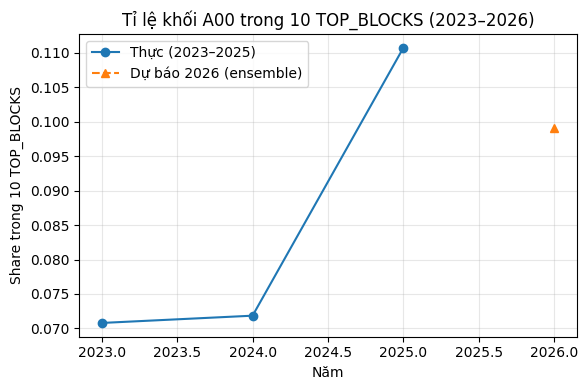

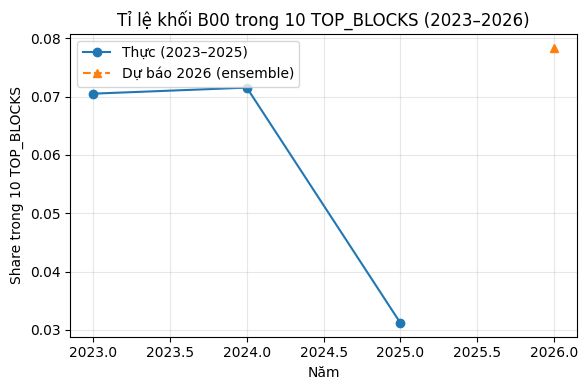

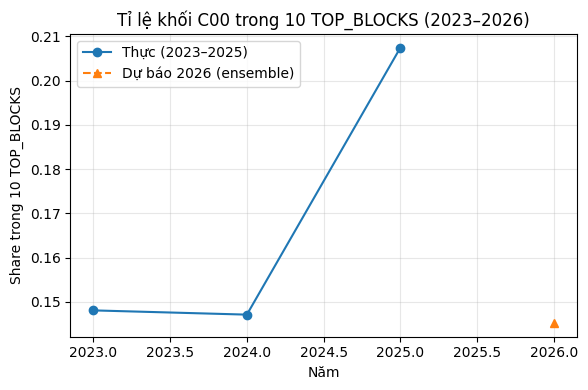

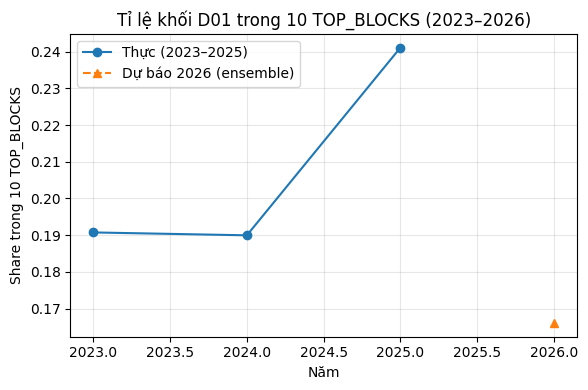


Bảng share 2026 (final):


,nam_hoc,khoi,share
0,2026,A00,0.099060
1,2026,A01,0.095297
2,2026,A02,0.071237
3,2026,A03,0.011207
4,2026,B00,0.078401
5,2026,C00,0.145253
6,2026,D01,0.166070
7,2026,D07,0.166654
8,2026,D08,0.070298
9,2026,D09,0.096523


In [59]:
import matplotlib.pyplot as plt

# ============================================
# [BLOCK-PLOT/EXPORT] Vẽ biểu đồ & gom CSV cho 2023–2026
# ============================================

# 4.1. Vẽ biểu đồ cho một vài khối tiêu biểu
blocks_to_plot = ["A00", "B00", "C00", "D01"]  # có thể đổi thêm

for blk in blocks_to_plot:
    df_hist = df_top[df_top["khoi"] == blk].sort_values("nam_hoc").copy()
    if df_hist.empty:
        continue

    row_2026 = df_pred_2026_final[df_pred_2026_final["khoi"] == blk]
    if row_2026.empty:
        continue

    share_2026 = float(row_2026["share_2026_final"].iloc[0])

    years_hist = df_hist["nam_hoc"].values
    shares_hist = df_hist["share_in_year"].values

    plt.figure(figsize=(6, 4))
    plt.plot(years_hist, shares_hist, marker="o", linestyle="-",
             label="Thực (2023–2025)")

    plt.plot([YEAR_FORECAST], [share_2026],
             marker="^", linestyle="--",
             label=f"Dự báo {YEAR_FORECAST} (ensemble)")

    plt.title(f"Tỉ lệ khối {blk} trong 10 TOP_BLOCKS (2023–{YEAR_FORECAST})")
    plt.xlabel("Năm")
    plt.ylabel("Share trong 10 TOP_BLOCKS")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 4.2. Gom 2023–2026 vào 1 bảng để dùng cho Report / dashboard
df_block_share_2023_2026 = pd.concat([
    df_top[["nam_hoc", "khoi", "share_in_year"]].rename(columns={"share_in_year": "share"}),
    df_pred_2026_final[["nam_hoc", "khoi", "share_2026_final"]].rename(columns={"share_2026_final": "share"})
], ignore_index=True)

df_block_share_2023_2026 = df_block_share_2023_2026.sort_values(["khoi", "nam_hoc"]).reset_index(drop=True)

print("\nBảng share 2026 (final):")
display(df_block_share_2023_2026[df_block_share_2023_2026["nam_hoc"] == YEAR_FORECAST].reset_index(drop=True))

# (tuỳ chọn) lưu file
# df_block_share_2023_2026.to_csv("block_share_2023_2026_ensemble_multi_arima.csv", index=False)
# print("💾 Đã lưu block_share_2023_2026_ensemble_multi_arima.csv")



#### Nhận xét và hạn chế

- Tỉ lệ một số khối truyền thống (A00, B00, C00, D01, D07, …) giảm mạnh năm 2025 do thay đổi chương trình thi (điểm gãy).
- Dự báo 2026 **không kéo thẳng trend 2023–2024**, mà giả định:
  - 2025 là năm đầu của regime mới,
  - 2026 dao động xung quanh phân bố 2025 với biên độ được kiểm soát.
- Hạn chế:
  - Dữ liệu hậu gãy còn ít (mới chỉ có 1 năm 2025),
  - Dự báo 2026 nên được coi là **kịch bản tham khảo** hơn là dự đoán chính xác tuyệt đối.